# Visium DLPFC

In this notebook we demonstrate how mosna can be used to analyze spatiallly resolved omics data.  
The data used is from the publication by [Maynard et al.](https://www.nature.com/articles/s41593-020-00787-0) "Transcriptome-scale spatial gene expression in the human dorsolateral prefrontal cortex".  
Here 12 samples were processed with the [Visium](https://www.science.org/doi/10.1126/science.aaf2403) platform to produce maps of transcripts per spots.  

## Imports and data loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from time import time
import warnings
import joblib
from pathlib import Path
from time import time
from tqdm import tqdm
import copy
import matplotlib as mpl
import napari
import colorcet as cc
import composition_stats as cs
from sklearn.impute import KNNImputer
from lifelines import KaplanMeierFitter, CoxPHFitter

import anndata as ad
import scanpy as sc
import scvi

from tysserand import tysserand as ty
from mosna import mosna

import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = 'white'
mpl.rcParams["axes.facecolor"] = 'white'
mpl.rcParams["savefig.facecolor"] = 'white'

Global seed set to 0


In [2]:
# If need to reload modules after their modification
from importlib import reload
ty = reload(ty)
mosna = reload(mosna)

### Objects data

Load files that contains all the detected objects (the cells) across all samples and clinical data.  
Data is available here: https://github.com/LieberInstitute/HumanPilot/tree/master and at [Globus](http://research.libd.org/globus/) (`jhpce#HumanPilot10x`).

In [3]:
data_dir = Path("../../HumanPilot/10X/")
sample_ids = [
    '151507', 
    '151508', 
    '151509', 
    '151510', 
    '151669', 
    '151670', 
    '151671', 
    '151672', 
    '151673', 
    '151674', 
    '151675', 
    '151676'
]

In [4]:
annotations = pd.read_csv(data_dir / 'barcode_level_layer_map.tsv', sep='\t', header=None)
annotations.columns = ['barcodes', 'sample_id', 'layer']
# make unique barcodes with sample_id
annotations['barcodes'] = annotations['barcodes'] + '-' + annotations['sample_id'].astype(str)
annotations

,barcodes,sample_id,layer
0,AAACAACGAATAGTTC-1-151507,151507,L1
1,AAACAAGTATCTCCCA-1-151507,151507,L3
2,AAACAATCTACTAGCA-1-151507,151507,L1
3,AAACACCAATAACTGC-1-151507,151507,WM
4,AAACAGCTTTCAGAAG-1-151507,151507,L6
...,...,...,...
47324,TTGTTGTGTGTCAAGA-1-151676,151676,L6
47325,TTGTTTCACATCCAGG-1-151676,151676,WM
47326,TTGTTTCATTAGTCTA-1-151676,151676,WM
47327,TTGTTTCCATACAACT-1-151676,151676,L6


In [5]:
annotations['sample_id'].value_counts()

sample_id
151509    4788
151510    4595
151508    4381
151507    4221
151671    4093
151672    3888
151669    3636
151674    3635
151673    3611
151675    3566
151670    3484
151676    3431
Name: count, dtype: int64

In [6]:
# # rename files to use `sc.read_visium`
# for sample_id in sample_ids:
#     path_dir = data_dir / f'{sample_id}'
#     path_dir_spatial = path_dir / 'spatial'
#     path_dir_spatial.mkdir(parents=True, exist_ok=True)

#     for path, directories, files in os.walk(path_dir):
#         for file in files:
#             if file.startswith(sample_id):
#                 new_name = file.replace(f'{sample_id}_', '')
#                 os.rename(os.path.join(path, file), os.path.join(path, new_name))
#             if file == 'tissue_positions_list.txt':
#                 os.rename(os.path.join(path, file), os.path.join(path_dir_spatial, 'tissue_positions_list.csv'))
#             elif file.endswith('res_image.png'):
#                 os.rename(os.path.join(path, file), os.path.join(path_dir_spatial, file))
#             elif file == 'scalefactors_json.json':
#                 os.rename(os.path.join(path, file), os.path.join(path_dir_spatial, file))

### Explore single sample

In [8]:
hvgs=5000

sample_id = sample_ids[0]
sample_dir = data_dir / f'{sample_id}'
adata = sc.read_visium(path=sample_dir)
adata.var_names_make_unique()

sc.pp.filter_genes(adata, min_counts=3)
sc.pp.filter_cells(adata, min_counts=3)

adata.layers["counts"] = adata.X.copy()
# sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=hvgs,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# make unique barcodes with sample_id
adata.obs.index = adata.obs.index + '-' + str(sample_id)

/home/alexis/miniconda3/envs/mosna-dl/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/alexis/miniconda3/envs/mosna-dl/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [9]:
adata

AnnData object with n_obs × n_vars = 4226 × 5000
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'hvg', 'log1p'
    obsm: 'spatial'
    layers: 'counts'

In [10]:
layer_guess = annotations.loc[annotations['sample_id'] == int(sample_id)]
layer_guess.index = layer_guess['barcodes']
layer_guess.index.name = None
layer_guess = layer_guess.drop(columns=['barcodes', 'sample_id'])

adata.obs['layer_guess'] = layer_guess
adata.obs.loc[adata.obs['layer_guess'].isna(), 'layer_guess'] = 'none'

In [11]:
adata.obs

,in_tissue,array_row,array_col,n_counts,layer_guess
AAACAACGAATAGTTC-1-151507,1,0,16,946.0,L1
AAACAAGTATCTCCCA-1-151507,1,50,102,4260.0,L3
AAACAATCTACTAGCA-1-151507,1,3,43,1967.0,L1
AAACACCAATAACTGC-1-151507,1,59,19,3367.0,WM
AAACAGCTTTCAGAAG-1-151507,1,43,9,2980.0,L6
...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1-151507,1,31,77,2337.0,L3
TTGTTTCACATCCAGG-1-151507,1,58,42,2331.0,L6
TTGTTTCATTAGTCTA-1-151507,1,60,30,819.0,WM
TTGTTTCCATACAACT-1-151507,1,45,27,3091.0,L6


In [12]:
adata.obs['layer_guess'].value_counts()

layer_guess
L3      1215
L1       817
L5       675
L6       486
L4       369
WM       354
L2       305
none       5
Name: count, dtype: int64

In [13]:
# make common color mapper
cycle_cmap = False

nodes_labels = adata.obs['layer_guess']
uniq = pd.Series(nodes_labels).value_counts().index

if nodes_labels is not None:
    nb_clust = len(uniq)
    uniq = pd.Series(nodes_labels).value_counts().index

    # choose colormap
    clusters_cmap = mosna.make_cluster_cmap(uniq)
    # make color mapper
    # series to sort by decreasing order
    n_colors = len(clusters_cmap)
    nodeclusters_color_mapper = {x: clusters_cmap[i % n_colors] for i, x in enumerate(uniq)}

In [14]:
nodeclusters_color_mapper

{'L3': '#1F77B4',
 'L1': '#FF7F0E',
 'L5': '#2CA02C',
 'L6': '#D62728',
 'L4': '#9467BD',
 'WM': '#8C564B',
 'L2': '#17BECF',
 'none': '#E377C2'}

In [15]:
adata.uns['spatial'][sample_id]['images']['hires'].shape

(2000, 2000, 3)

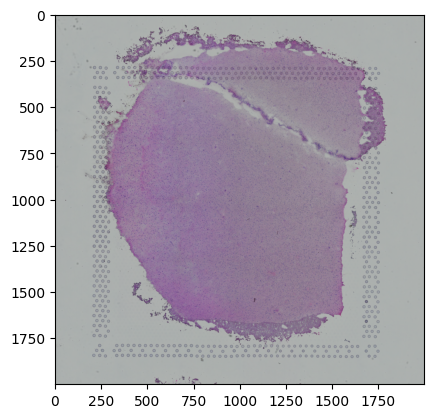

In [16]:
plt.imshow(adata.uns['spatial'][sample_id]['images']['hires']);

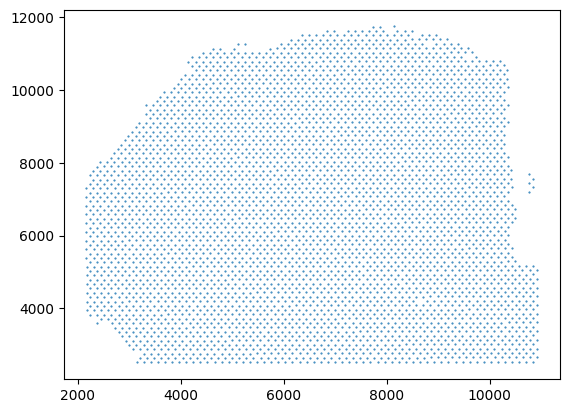

In [17]:
plt.scatter(adata.obsm['spatial'][:, 0], adata.obsm['spatial'][:, 1], s=1, marker='.');

In [18]:
coords = adata.obsm['spatial']
pairs = ty.build_lattice(coords)

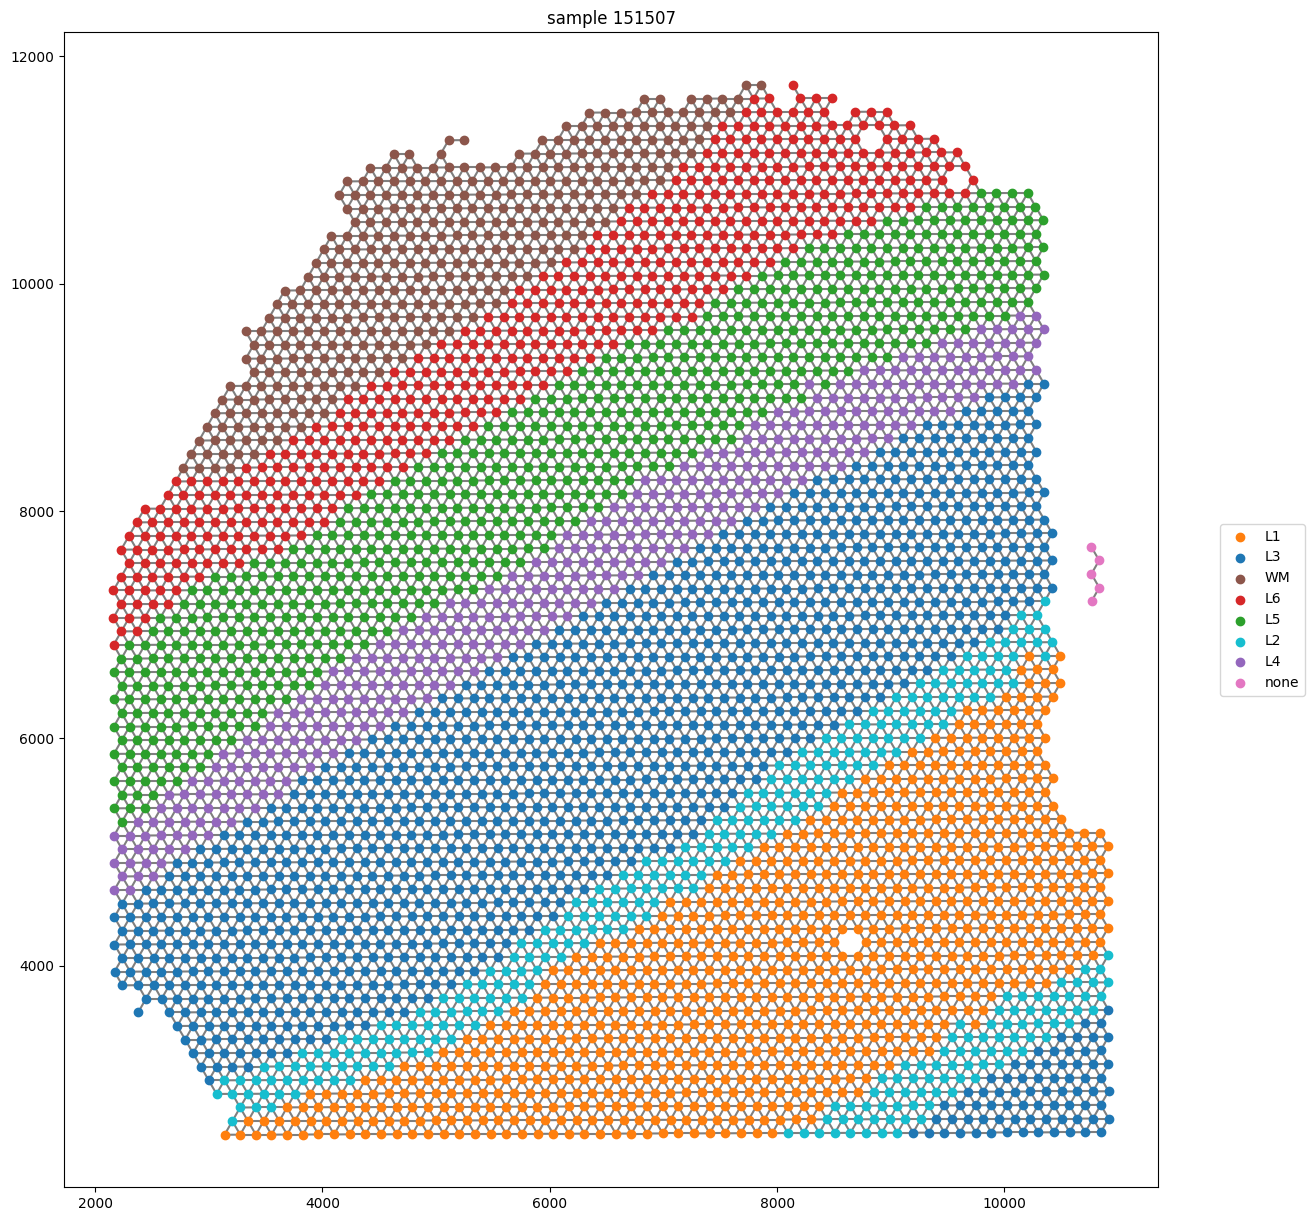

In [19]:
fig, ax = ty.plot_network(
    coords, pairs, labels=nodes_labels,
    color_mapper=nodeclusters_color_mapper, 
    legend_opt={'loc': 'center left', 'bbox_to_anchor': (1.05, 0.5)},
    )
plt.title("sample {}".format(sample_id));

In [19]:
adata

AnnData object with n_obs × n_vars = 4226 × 5000
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'layer_guess'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'hvg', 'log1p'
    obsm: 'spatial'
    layers: 'counts'

In [20]:
adata.layers['counts']

<4226x5000 sparse matrix of type '<class 'numpy.float32'>'
	with 1850390 stored elements in Compressed Sparse Row format>

In [21]:
n_zeros = np.sum(adata.layers['counts'] == 0)
n_finite = adata.layers['counts'].size
m, n = adata.layers['counts'].shape
print(m * n == n_finite + n_zeros)
print(n_zeros / (m *n))

/home/alexis/miniconda3/envs/mosna-dl/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3577: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


True
0.9124283009938476


## Cellular neighborhoods

In [90]:
order = 1
var_type = 'genexp'
stat_names = 'mean-std'
# aggreg_vars = pheno_cols

# For UMAP visualization
marker = '.'
size_points = 10

nas_dir = reconst_dir / f"nas_on-{var_type}_stats-{stat_names}_order-{order}"    
nas_dir.mkdir(parents=True, exist_ok=True)

In [107]:
order = 1
stat_funcs='default'
stat_names='default'
# stat_funcs = np.mean
# stat_names = 'mean'
var_names = adata.var.loc[adata.var['highly_variable']].index
    
nas = mosna.make_features_NAS(
    adata.layers['counts'].toarray(), 
    pairs, 
    order=order, 
    var_names=var_names, 
    stat_funcs=stat_funcs, 
    stat_names=stat_names, 
    )

In [108]:
nas

,FAM41C mean,AL390719.2 mean,ATAD3C mean,ATAD3B mean,AL691432.2 mean,MIB2 mean,GABRD mean,TNFRSF14 mean,TP73 mean,LRRC47 mean,...,ITGB2-AS1 std,LINC01547 std,ADARB1 std,POFUT2 std,SLC19A1 std,MT-CO1 std,MT-CO2 std,MT-CO3 std,AC145212.1 std,AL592183.1 std
0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.400000,0.000000,8.163333,12.076423,7.668116,0.0,0.000000
1,0.0,0.0,0.0,0.000000,0.142857,0.285714,0.571429,0.285714,0.000000,0.428571,...,0.0,0.000000,0.000000,0.000000,0.451754,31.851057,36.026634,22.852678,0.0,0.000000
2,0.0,0.0,0.0,0.000000,0.285714,0.285714,0.142857,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.349927,0.000000,7.989789,12.126880,7.928250,0.0,0.000000
3,0.0,0.0,0.0,0.000000,0.166667,1.000000,0.333333,0.166667,0.000000,0.333333,...,0.0,0.000000,0.372678,0.000000,0.000000,5.557778,10.656244,9.464848,0.0,0.372678
4,0.0,0.0,0.0,0.000000,0.000000,0.142857,0.571429,0.142857,0.000000,0.285714,...,0.0,0.000000,0.451754,0.000000,0.000000,6.761234,16.334513,15.919440,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4221,0.0,0.0,0.0,0.000000,0.000000,0.142857,0.428571,0.000000,0.000000,0.571429,...,0.0,0.000000,0.451754,0.000000,0.349927,9.642592,21.191065,15.031939,0.0,0.000000
4222,0.0,0.0,0.0,0.142857,0.000000,0.000000,0.714286,0.000000,0.000000,0.285714,...,0.0,0.000000,0.000000,0.000000,0.000000,15.997449,17.435596,15.952736,0.0,0.000000
4223,0.0,0.0,0.0,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.285714,...,0.0,0.000000,0.000000,0.000000,0.000000,5.337584,6.904597,6.411087,0.0,0.000000
4224,0.0,0.0,0.0,0.000000,0.000000,0.142857,0.285714,0.000000,0.142857,0.142857,...,0.0,0.699854,0.000000,0.000000,0.349927,4.140393,13.013337,8.580947,0.0,0.000000


### Pre-process all samples

In [5]:
cluster_ids = {
    '151507': 7, 
    '151508': 7, 
    '151509': 7, 
    '151510': 7, 
    '151669': 5, 
    '151670': 5, 
    '151671': 5, 
    '151672': 5, 
    '151673': 7, 
    '151674': 7, 
    '151675': 7, 
    '151676': 7,
    }

patient_ids = {
    '151507': 0, 
    '151508': 0, 
    '151509': 0, 
    '151510': 0, 
    '151669': 1, 
    '151670': 1, 
    '151671': 1, 
    '151672': 1, 
    '151673': 2, 
    '151674': 2, 
    '151675': 2, 
    '151676': 2,
    }

In [24]:
# cohort aggregation
hvgs = 5000

adatas = []
for sample_id, n_clusters in cluster_ids.items():
    sample_dir = data_dir / f'{sample_id}'
    adata = sc.read_visium(path=sample_dir)
    adata.var_names_make_unique()
    # adata.obs_names_make_unique()
    adata.obs['sample'] = [sample_id] * adata.shape[0]
    adata.obs['patient'] = [patient_ids[sample_id]] * adata.shape[0]

    # make unique barcodes with sample_id
    adata.obs.index = adata.obs.index + '-' + str(sample_id)
    
    adatas.append(adata)

adata = ad.concat(adatas, pairwise=True)
# adata.var_names_make_unique()

sc.pp.filter_genes(adata, min_counts=3)
sc.pp.filter_cells(adata, min_counts=3)

adata.layers["counts"] = adata.X.copy()

sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(
    adata,
    n_top_genes=hvgs,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
)

# add manual annotations
layer_guess = annotations.copy()
layer_guess.index = layer_guess['barcodes']
layer_guess.index.name = None
layer_guess = layer_guess.drop(columns=['barcodes', 'sample_id'])
adata.obs['layer_guess'] = layer_guess
adata.obs.loc[adata.obs['layer_guess'].isna(), 'layer_guess'] = 'none'

# make common color mapper
nodes_labels = adata.obs['layer_guess']
uniq = pd.Series(nodes_labels).value_counts().index

if nodes_labels is not None:
    nb_clust = len(uniq)
    uniq = pd.Series(nodes_labels).value_counts().index

    # choose colormap
    clusters_cmap = mosna.make_cluster_cmap(uniq)
    # make color mapper
    # series to sort by decreasing order
    n_colors = len(clusters_cmap)
    nodeclusters_color_mapper = {x: clusters_cmap[i % n_colors] for i, x in enumerate(uniq)}

In [25]:
adata

AnnData object with n_obs × n_vars = 47681 × 5000
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'patient', 'n_counts', 'layer_guess'
    var: 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg'
    obsm: 'spatial'
    layers: 'counts'

In [19]:
# adata.obs_names_make_unique() # manually done

In [ ]:
# batch correction
n_latent = 5
seed = 0
scvi.settings.seed = seed

scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="patient")
model = scvi.model.SCVI(adata, n_latent=n_latent)
model.train(early_stopping=True)
adata.obsm['X_scVI'] = model.get_latent_representation(adata).astype(np.float32)

In [16]:
adata.write(data_dir / f"batch_corrected_hvgs{hvgs}_nlatent{n_latent}_joint.h5ad")

Use scanorama to perform batch correction

In [12]:
import scanpy.external as sce

In [15]:
sc.tl.pca(adata)
sce.pp.scanorama_integrate(adata, 'patient')

[[0.         0.67366429 0.3439627 ]
 [0.         0.         0.71685451]
 [0.         0.         0.        ]]
Processing datasets 1 <=> 2
Processing datasets 0 <=> 1
Processing datasets 0 <=> 2


In [18]:
adata.obsm['X_scanorama'].shape

(36155, 50)

#### Scanorama batch correction of counts

Scanpy makes it mandatory to run scanorama on PCA components, but we want batch-corrected gene expression, so we'll directly use scanorama.

In [26]:
# check batch effect first
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
adata.obs['patient'] = adata.obs['patient'].astype('category')

/home/alexis/miniconda3/envs/mosna-dl/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/alexis/miniconda3/envs/mosna-dl/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


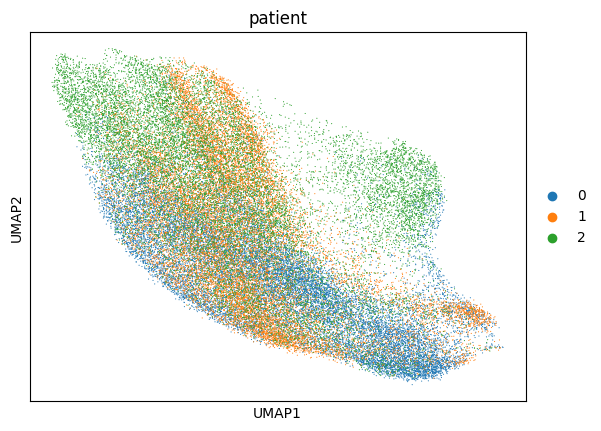

In [27]:
sc.pl.umap(
    adata, 
    color=['patient'],
)

In [28]:
import scanorama

# # Integration.
# scanorama.integrate_scanpy(adatas)

# Batch correction.
# make list of AnnData object per batch key
batch_key = 'patient'
uniq_keys = adata.obs[batch_key].unique()
adatas = [adata[adata.obs[batch_key] == key] for key in uniq_keys]

corrected = scanorama.correct_scanpy(adatas)

Found 5000 genes among all datasets
[[0.         0.61731222 0.28188527]
 [0.         0.         0.60350694]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


In [29]:
adata = ad.concat(corrected, pairwise=True)
# adata.obs_names_make_unique()
adata.write(data_dir / f"batch_corrected_scanorama.h5ad")

In [6]:
adata = sc.read_h5ad(data_dir / f"batch_corrected_scanorama.h5ad")

# make common color mapper
nodes_labels = adata.obs['layer_guess']
uniq = pd.Series(nodes_labels).value_counts().index

nb_clust = len(uniq)
uniq = pd.Series(nodes_labels).value_counts().index

# choose colormap
clusters_cmap = mosna.make_cluster_cmap(uniq)
# make color mapper
# series to sort by decreasing order
n_colors = len(clusters_cmap)
nodeclusters_color_mapper = {x: clusters_cmap[i % n_colors] for i, x in enumerate(uniq)}

In [7]:
adata

AnnData object with n_obs × n_vars = 47681 × 5000
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'patient', 'n_counts', 'layer_guess'
    obsm: 'X_pca', 'X_umap', 'spatial'

/home/alexis/miniconda3/envs/mosna-dl/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/alexis/miniconda3/envs/mosna-dl/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


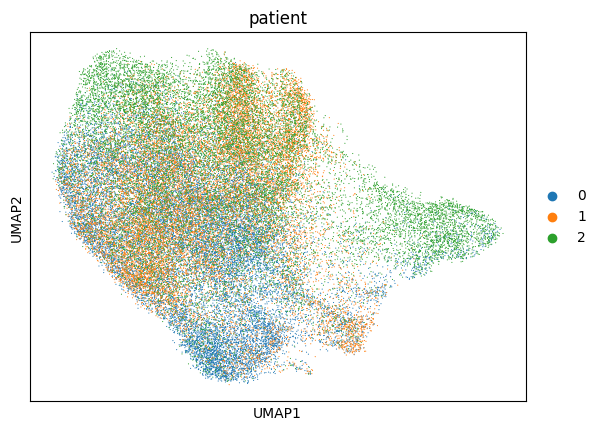

In [12]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

sc.pl.umap(
    adata, 
    color=['patient'],
)

### All samples network reconstruction

In [8]:
use_data = 'log1p'  # or 'raw'

processed_dir = Path('../data/processed/Visium_DLPFC')
reconst_dir = processed_dir / f"samples_networks_hexagonal_lattice_data-{use_data}"
dir_fig_save = processed_dir / 'figures'
reconst_dir.mkdir(parents=True, exist_ok=True)
dir_fig_save.mkdir(parents=True, exist_ok=True)

In [11]:
uniq_patients = adata.obs['patient'].unique()
uniq_samples = adata.obs['sample'].unique()

make_figures = False

for sample_id in uniq_samples:
    print(f"processing sample {sample_id}")
    adaview = adata[adata.obs['sample'] == sample_id]
    patient_id = adaview.obs['patient'].iloc[0]

    coords = adaview.obsm['spatial']
    pairs = ty.build_lattice(coords)
    # add annotations
    nodes_labels = adaview.obs['layer_guess']

    if make_figures:
        fig, ax = ty.plot_network(
            coords, pairs, labels=nodes_labels,
            color_mapper=nodeclusters_color_mapper, 
            legend_opt={'loc': 'center left', 'bbox_to_anchor': (1.05, 0.5)},
            )
        title = f"patient-{patient_id}_sample-{sample_id}"
        plt.title(title);
        plt.axis('off');
        plt.savefig(str(dir_fig_save / title) + '.png', bbox_inches='tight', facecolor='white')
        # plt.show()
        plt.close(fig)


    edges = pd.DataFrame(data=pairs, columns=['source', 'target'])
    edges.to_parquet(reconst_dir / f'edges_patient-{patient_id}_sample-{sample_id}.parquet', index=False)

    if use_data == 'raw':
        data = adaview.X.toarray()
    elif use_data == 'log1p':
        data = np.log(adaview.X.toarray() + 1)
    nodes = pd.DataFrame(
        data=adaview.X.toarray(),
        columns=adaview.var_names,
        index=adaview.obs_names,
    )
    nodes.to_parquet(reconst_dir / f'nodes_patient-{patient_id}_sample-{sample_id}.parquet', index=False)

del data, nodes, edges, coords, pairs

processing sample 151507
processing sample 151508
processing sample 151509
processing sample 151510
processing sample 151669
processing sample 151670
processing sample 151671
processing sample 151672
processing sample 151673
processing sample 151674
processing sample 151675
processing sample 151676


## Cellular neighborhoods

In [9]:
order = 1
var_type = 'counts'
stat_names = 'mean-std'
# stat_funcs='default'
# stat_names='default'
# stat_funcs = np.mean
# stat_names = 'mean'
# aggreg_vars = pheno_cols

# For UMAP visualization
marker = '.'
size_points = 10

nas_dir = reconst_dir / f"nas_on-{var_type}_stats-{stat_names}_order-{order}"    
nas_dir.mkdir(parents=True, exist_ok=True)

In [32]:
reload(ty)
reload(mosna)

<module 'mosna.mosna' from '/home/alexis/Pro/Postdoc_CRCT/Projects/mosna_benchmark/mosna/mosna.py'>

In [10]:
filename = nas_dir / f'aggregation_statistics.parquet'

if filename.exists():
    print('Load aggregation statistics')
    var_aggreg = pd.read_parquet(filename)
else:
    var_aggreg = mosna.compute_NAS_all_networks(
        net_dir=reconst_dir, 
        attributes_col=None, # use all variables
        use_attributes=None, # use all variables 
        make_onehot=False, 
        id_level_1='patient',
        id_level_2='sample', 
        extension='parquet',
        data_index=None,
        parallel_groups=False, #'max', 
        memory_limit='max',
        save_intermediate_results=False, 
        dir_save_interm=None,
        verbose=1,
        )
    var_aggreg.to_parquet(filename, index=False)

Load aggregation statistics


In [11]:
var_aggreg

,AASDHPPT mean,AATK mean,ABCA2 mean,ABCA8 mean,ABCB1 mean,ABCC12 mean,ABCC8 mean,ABCC9 mean,ABCG5 mean,ABHD17B mean,...,ZNHIT6 std,ZRSR2 std,ZSCAN29 std,ZSWIM4 std,ZSWIM6 std,ZWILCH std,ZXDA std,ZYG11B std,patient,sample
0,0.011368,0.009450,0.008933,0.000059,0.000011,-0.000424,-0.000230,-0.000259,-5.046072e-05,-0.000832,...,0.000798,0.000112,0.012394,0.000066,0.000102,0.000062,0.000025,0.018480,1,151672
1,0.021557,0.024007,0.018141,0.003648,0.000009,0.004218,-0.000142,-0.000260,-4.833985e-05,0.007776,...,0.001863,0.008843,0.000779,0.010972,0.010962,0.000534,0.000023,0.017354,1,151672
2,0.012881,0.027424,0.012487,0.000632,0.000029,0.000195,0.007372,-0.000260,-4.377017e-05,0.000396,...,0.000131,0.002399,0.016260,0.000048,0.012868,0.000028,0.000013,0.020618,1,151672
3,0.010719,0.016393,0.007529,0.000050,0.000029,-0.000405,0.000351,-0.000253,-3.935305e-05,0.005249,...,0.018661,0.017156,0.000019,0.000038,0.015681,0.000054,0.000011,0.018068,1,151672
4,0.027677,0.014835,0.026473,0.004287,0.000459,0.004421,0.004401,-0.000247,-5.278672e-05,0.003308,...,0.011132,0.010382,0.000867,0.000033,0.001021,0.000084,0.000010,0.017698,1,151672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47676,0.005478,0.014506,0.035781,0.005112,0.000112,-0.000708,-0.001347,-0.000164,-1.457201e-06,0.007580,...,0.015632,0.012352,0.014931,0.000038,0.016691,0.000754,0.000026,0.001574,2,151674
47677,0.001656,0.033103,0.034956,0.000930,0.005397,-0.000379,0.003217,-0.000177,-2.202927e-09,0.004619,...,0.015729,0.008439,0.000089,0.000023,0.014250,0.000624,0.000011,0.016260,2,151674
47678,0.007857,0.018144,0.010221,0.008308,0.005253,-0.000625,0.003885,0.000254,-9.682577e-06,0.004140,...,0.000185,0.002118,0.000079,0.000018,0.002172,0.011002,0.000012,0.011850,2,151674
47679,0.008043,0.006458,0.011001,0.001180,0.000491,-0.000308,-0.000519,-0.000143,-7.241336e-07,0.001209,...,0.001974,0.000442,0.000188,0.000045,0.002029,0.000094,0.000020,0.003104,2,151674


In [12]:
# retrieve network info and remove it from NAS table
var_aggreg_samples_info = var_aggreg[['patient', 'sample']]
var_aggreg.drop(columns=['patient', 'sample'], inplace=True)

In [13]:
cluster_params = {
    'reducer_type': 'umap', 
    'n_neighbors': 15, 
    'metric': 'euclidean',
    'min_dist': 0.0,
    'clusterer_type': 'leiden', 
    'dim_clust': 2, 
    'k_cluster': 15, 
    'resolution_parameter': 0.05,
}

cluster_labels, cluster_dir, nb_clust, _ = mosna.get_clusterer(var_aggreg, nas_dir, **cluster_params)

Loading clusterer object and cluster labels
There are 14 clusters


Loading reducer object and reduced coordinates


(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

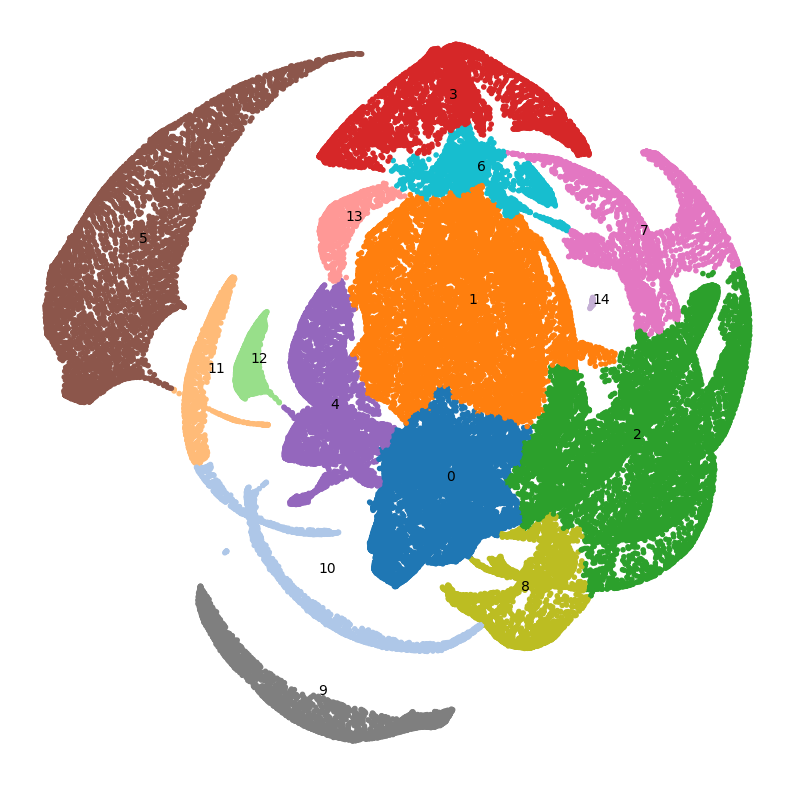

In [14]:
fig, ax = embed_viz, _ = mosna.get_reducer(
    var_aggreg, 
    nas_dir, 
    reducer_type='umap', 
    n_neighbors=15, 
    metric='euclidean',
    )

mosna.plot_clusters(embed_viz, cluster_labels, nas_dir, cluster_params=cluster_params)